# ** 0. Environment **

In [229]:
from google.colab import drive, files
# drive.mount('/content/drive')
# file_path = '/content/drive/MyDrive'

from collections import deque
import re

import pandas as pd
import os

import numpy as np

# ** 1. Data Set **

In [230]:
## Function :: Convert text 2 list
def Category_binder(perfume, col_num):

    ## 01. 대카테고리 분류
    category = []
    if '"' not in perfume[col_num]:
        category.append(perfume[col_num])
        perfume[col_num] = category
    else:
        category.append(perfume[col_num].replace('"', '').strip())
        while True:
            a_item = perfume.pop(col_num + 1)
            if '"' not in a_item:

                category.append(a_item.strip())
            else:
                category.append(a_item.replace('"', '').strip())
                break
        perfume[col_num] = category


    ## 02. 카테고리 내부 단어 전처리
    new = set()
    qq = deque(perfume[col_num])
    while qq:
        item = qq.popleft().lower()
        item = item.replace('-', '').strip()
        item = item.replace('(', '').strip()
        item = item.replace(')', '').strip()
        if 'and' in item:
            not_and, is_and = [], False
            temp = list(item.split())
            for j in range(len(temp)):
                if temp[j] == 'and':
                    is_and = True
                    continue
                not_and.append(temp[j])
            if is_and:
                for k in range(len(not_and)):
                    new.add(not_and[k])
            else:
                new.add(item)
        else:
            new.add(item)
    perfume[col_num] = new
    return perfume

## Function :: Convert list 2 txt
def TextMaker(name, catego):
    text = ''
    for tt in sorted(list(catego)):
        text += str(tt)
        text += ', '
    with open(name + '.txt', 'w') as f:
        f.write(text[:-2])

In [231]:
## 01. 파일 읽기
perfumes_dataset = open("/content/noon_perfumes_dataset.csv")
perfumes_dataset = perfumes_dataset.read()
perfumes_dataset = perfumes_dataset.replace('\n', ',').split(',')
perfumes = [] 
perfumes_tag = perfumes_dataset[:15]
perfumes_data = perfumes_dataset[15:]


## 02. 향수 별로 구분하기 ...  perfumes : [ [향수1], [향수2], ....]
idx = '1'
perfume_now = []
for data in perfumes_data:
    if data == idx:
        idx = str(int(idx) + 1)
        perfumes.append(perfume_now)
        perfume_now = []
    perfume_now.append(data)
perfumes.append(perfume_now)


## 03. 향수 내 대분류 정리
for perfume in perfumes:
    ## 03-1. old_price / new_price / ml -->> str2float
    perfume[3], perfume[4], perfume[5] = float(perfume[3]), float(perfume[4]), float(perfume[5])

    ## 03-2. scents - col no. 8
    perfume = Category_binder(perfume, 8)

    ## 03-3. base_note - col no. 9
    perfume = Category_binder(perfume, 9)

    ## 03-4. middle_note - col no. 10
    perfume = Category_binder(perfume, 10)

    ## 03-5. item_rating -->> str2float
    perfume[11] = float(perfume[11])


## 04. 향수 데이터 형식
# 0.no, 1.brand, 2.name, 3.old_price, 4.new_price, 5.mL, 6.Time_category, 7.gender, 8.Top, 9.base, 10.middle, 11.rating
all_brands = set()              # 01    150
all_names = set()               # 02    589
brand_plus_name = set()        #################
all_concentrations = set()      # 06    5
all_departments = set()         # 07    4
all_scents = set()              # 08    18
all_bases = set()               # 09    426
all_middles = set()             # 10    606

for perfume in perfumes:
    all_brands.add(perfume[1].lower())
    all_names.add(perfume[2].lower())
    brand_plus_name.add((perfume[1].lower(), perfume[2].lower()))
    all_concentrations.add(perfume[6].lower())
    all_departments.add(perfume[7].lower())
    for pt in perfume[8]:
        all_scents.add(pt.lower())
    for pb in perfume[9]:
        all_bases.add(pb.lower())
    for pm in perfume[10]:
        all_middles.add(pm.lower())

# ** 2. Data purification

In [112]:
# print(len(all_scents))
# print(len(all_bases))
# print(len(all_middles))
# print(len(all_bases & all_middles))

11
426
606
166


In [232]:
scents_sorted = sorted(list(all_scents))
notes_sorted = sorted(list(all_middles | all_bases))[5:]

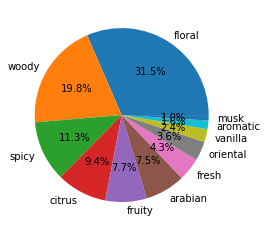

In [233]:
### 점유율 확인 ~ 파이 그래프
import matplotlib.pyplot as plt

share = []
scents_perfumes = [0] * len(scents_sorted)
for perfume in perfumes:
    for scent in perfume[8]:
        scents_perfumes[scents_sorted.index(scent)] += 1

for i in range(len(scents_sorted)):
    share.append((round(scents_perfumes[i]/1003*100, 2), scents_sorted[i]))
share = sorted(share, reverse=True)

ratio = []
labels = []
for sha in share:
    ratio.append(sha[0])
    labels.append(sha[1])
plt.pie(ratio, labels=labels, autopct='%.1f%%')
plt.show()

In [236]:
## 05. 데이터 카테고라이징
# 0.no, 1.brand, 2.name, 3.old_price, 4.new_price, 5.mL, 6.Time_category, 7.gender, 8.Top, 9.base, 10.middle, 11.rating
scents2notes = {}
for top in all_scents:
    scents2notes[top] = [set(), set(), set()]
    for perfume in perfumes:
        if top in perfume[8]:
            for pm in perfume[10]:
                scents2notes[top][0].add(pm)
            for pb in perfume[9]:
                scents2notes[top][1].add(pb)
            scents2notes[top][2] = scents2notes[top][0] | scents2notes[top][1]
    print(top, scents2notes[top])
## 저장해보기 ## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

woody [{'wood', 'black orchid', 'guaiac tree', 'pineapple', 'incense', 'dark', 'heliotrope', 'woody notes', 'floral notes', 'muget', 'ylangylang', 'caraway', 'sandalwood', 'black basil', 'bay leaf', 'cardamom', 'bamboo', 'birch leaf', 'american', 'ambergris', 'basil', 'oudh', 'pine tree needles', 'cyclamen', 'guaiac wood', 'ambrofix', 'floral spicy', 'orange blossom', 'pelargonium', 'lilyofthevalley', 'asphalt', 'sea', 'rose geranium', 'lily of the valley', 'lavandin', 'caramel', 'water', 'woodsy notes of oakmoss', 'of', 'labdanum', 'clary sage', 'blue orris accord', 'freesia', 'pine', 'cloves', 'apple', 'jasmin', 'cashmere wood', 'honey', 'jasmine', 'ylang', 'tropical fruits', 'benzoin', 'nutmeg', 'rose', 'spicy notes', 'tonka bean', 'heart', 'brazilian', 'tanzanian', 'turkish', 'mimose', 'moss', 'vetiver', 'cedar', 'tuberose', 'orange', 'peony', 'bulgarian rose', 'vanilla', 'white pepper', 'shaving soap', 'with', 'chinese cedar', 'turkish rose', 'black', 'tree', 'cinnamon', 'african'

In [239]:
### Category Purification
tango_top = 'musk'
tango_middle = scents2notes[tango_top][0]
tango_base = scents2notes[tango_top][1]
tango_all = tango_middle | tango_base

for scent in scents_sorted:
    now_middle = scents2notes[scent][0]
    now_base = scents2notes[scent][1]
    now_all = now_middle | now_base
    print(scent, len(tango_middle & now_middle), len(tango_base & now_base))

arabian 12 10
aromatic 4 7
citrus 9 9
floral 12 11
fresh 8 9
fruity 9 9
musk 15 12
oriental 8 8
spicy 9 10
vanilla 6 8
woody 13 10


In [240]:
### Sparse Matrix -> Dense Matrix
TailCutter = {}
Head = set()
Tail = set()
for scent in scents_sorted:
    temp = {}
    for perfume in perfumes:
        if scent in perfume[8]:
            now_all = perfume[10] | perfume[9]
            for now in now_all:
                if now in temp:
                    temp[now] += 1
                else:
                    temp[now] = 1
    TailCutter[scent] = sorted(temp.items(), key=lambda x: x[1], reverse=True)

In [245]:
for scent in scents_sorted:
    print(scent, len(TailCutter[scent]), TailCutter[scent])

arabian 168 [('vanilla', 28), ('musk', 25), ('amber', 23), ('sandalwood', 22), ('tonka bean', 22), ('patchouli', 21), ('rose', 21), ('jasmine', 20), ('cedar', 16), ('geranium', 16), ('benzoin', 12), ('vetiver', 11), ('iris', 7), ('orange blossom', 6), ('orris', 6), ('white musk', 6), ('sugar', 6), ('cinnamon', 5), ('tuberose', 5), ('apple', 5), ('violet', 5), ('magnolia', 5), ('wood', 4), ('vanille', 4), ('african orange flower', 4), ('oud', 4), ('cashmere wood', 4), ('jasmine sambac', 4), ('ylangylang', 4), ('tonka', 4), ('oakmoss', 4), ('pepper', 4), ('lilyofthevalley', 4), ('lavender', 4), ('saffron', 4), ('ebony', 3), ('woodsy notes', 3), ('cocoa', 3), ('praline', 3), ('bulgarian rose', 3), ('gardenia', 3), ('peony', 3), ('tonka beans', 3), ('rose petals', 3), ('wisteria', 3), ('green', 3), ('ginger', 3), ('heliotrope', 3), ('bean', 3), ('nutmeg', 3), ('ambroxan', 3), ('mint', 2), ('moss', 2), ('lemon', 2), ('spicy', 2), ('agarwood', 2), ('bergamot', 2), ('orange tree blossom', 2),

arabian 168 [('vanilla', 28), ('musk', 25), ('amber', 23), ('sandalwood', 22), ('tonka bean', 22), ('patchouli', 21), ('rose', 21), ('jasmine', 20), ('cedar', 16), ('geranium', 16), ('benzoin', 12), ('vetiver', 11), ('iris', 7), ('orange blossom', 6), ('orris', 6), ('white musk', 6), ('sugar', 6), ('cinnamon', 5), ('tuberose', 5), ('apple', 5), ('violet', 5), ('magnolia', 5), ('wood', 4), ('vanille', 4), ('african orange flower', 4), ('oud', 4), ('cashmere wood', 4), ('jasmine sambac', 4), ('ylangylang', 4), ('tonka', 4), ('oakmoss', 4), ('pepper', 4), ('lilyofthevalley', 4), ('lavender', 4), ('saffron', 4), ('ebony', 3), ('woodsy notes', 3), ('cocoa', 3), ('praline', 3), ('bulgarian rose', 3), ('gardenia', 3), ('peony', 3), ('tonka beans', 3), ('rose petals', 3), ('wisteria', 3), ('green', 3), ('ginger', 3), ('heliotrope', 3), ('bean', 3), ('nutmeg', 3), ('ambroxan', 3), ('mint', 2), ('moss', 2), ('lemon', 2), ('spicy', 2), ('agarwood', 2), ('bergamot', 2), ('orange tree blossom', 2),

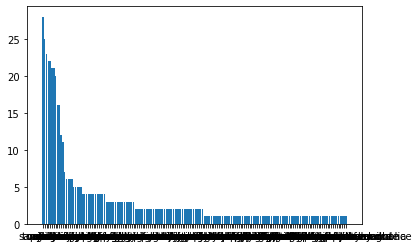

aromatic 58 [('sandalwood', 8), ('oakmoss', 8), ('geranium', 8), ('patchouli', 7), ('jasmine', 7), ('vetiver', 6), ('carnation', 6), ('musk', 6), ('amber', 6), ('leather', 5), ('sage', 5), ('cedar', 5), ('vanilla', 4), ('fir', 4), ('gardenia', 3), ('nutmeg', 3), ('tonka bean', 3), ('rosemary', 2), ('cedar wood', 2), ('benzoin', 2), ('cinnamon', 2), ('caraway', 2), ('fern', 2), ('cyclamen', 2), ('rose', 2), ('tobacco', 2), ('neroli', 2), ('ambery woods', 1), ('brazilian rosewood', 1), ('labdanum', 1), ('coriander', 1), ('lavender sage', 1), ('woody notes', 1), ('patchouli leaves', 1), ('luxurious notes of whiskey', 1), ('tonka', 1), ('myrrh', 1), ('civet', 1), ('orris root', 1), ('pepper', 1), ('gaiac wood', 1), ('cloves', 1), ('orchid', 1), ('violet', 1), ('moss', 1), ('iris', 1), ('ylangylang', 1), ('spices', 1), ('virginia cedar', 1), ('cardamom with black tea leaves', 1), ('tonka beans', 1), ('woody', 1), ('masculine', 1), ('patchouli accords', 1), ('lavandin', 1), ('cedarwood', 1),

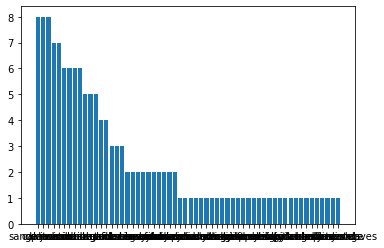

citrus 184 [('musk', 45), ('jasmine', 42), ('sandalwood', 37), ('patchouli', 36), ('cedar', 35), ('amber', 29), ('vanilla', 22), ('rose', 18), ('oakmoss', 14), ('vetiver', 13), ('nutmeg', 13), ('tonka bean', 10), ('geranium', 10), ('cardamom', 10), ('peony', 10), ('ambroxan', 8), ('wood', 8), ('violet', 8), ('cinnamon', 8), ('white musk', 7), ('coriander', 7), ('jasmine sambac', 7), ('woody notes', 7), ('heliotrope', 7), ('lavender', 6), ('pepper', 6), ('white', 6), ('lily', 6), ('ginger', 6), ('honeysuckle', 6), ('lily of the valley', 6), ('lemon blossom', 6), ('bean', 5), ('tonka', 5), ('sage', 5), ('tonka beans', 5), ('benzoin', 5), ('accord', 5), ('grapefruit', 5), ('lilyofthevalley', 5), ('orris root', 5), ('woodsy notes', 5), ('cashmere wood', 4), ('black pepper', 4), ('guaiac', 4), ('flower', 4), ('cloves', 4), ('woody', 4), ('virginia cedar', 4), ('rosewood', 4), ('water notes', 4), ('tobacco', 4), ('cacao pod', 3), ('clary', 3), ('zests', 3), ('ambregris', 3), ('heart', 3), ('

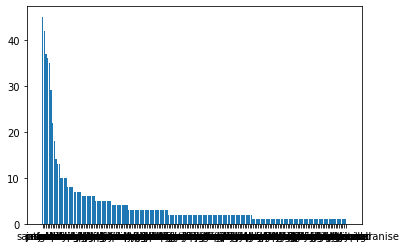

floral 424 [('jasmine', 150), ('musk', 132), ('sandalwood', 108), ('vanilla', 106), ('patchouli', 102), ('amber', 100), ('rose', 87), ('cedar', 49), ('vetiver', 37), ('tuberose', 33), ('gardenia', 28), ('ylangylang', 27), ('orange blossom', 25), ('lily', 23), ('peach', 23), ('violet', 22), ('iris', 22), ('heliotrope', 19), ('honey', 18), ('woody', 18), ('oakmoss', 17), ('peony', 17), ('geranium', 16), ('white musk', 16), ('tonka bean', 15), ('orchid', 15), ('flower', 15), ('orange', 15), ('ambergris', 14), ('incense', 14), ('lilyofthevalley', 13), ('wood', 13), ('honeysuckle', 13), ('lily of the valley', 13), ('freesia', 12), ('magnolia', 12), ('white', 12), ('coriander', 12), ('narcissus', 11), ('caramel', 11), ('neroli', 11), ('blossom', 11), ('cashmeran', 10), ('lotus', 10), ('carnation', 9), ('tonka', 9), ('bulgarian rose', 9), ('virginia cedar', 9), ('tiare flower', 9), ('orris root', 8), ('lavender', 8), ('woods', 8), ('notes', 8), ('benzoin', 8), ('apple', 7), ('moss', 7), ('sag

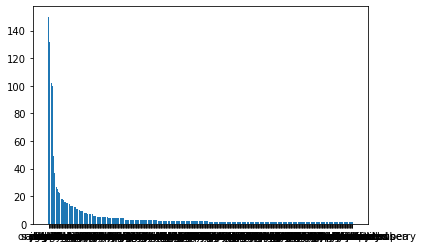

fresh 133 [('musk', 25), ('patchouli', 19), ('rose', 13), ('vanilla', 13), ('amber', 12), ('jasmine', 11), ('sandalwood', 10), ('cedar', 9), ('geranium', 8), ('tonka bean', 7), ('lavender', 6), ('sage', 6), ('ylangylang', 5), ('cardamom', 5), ('pine', 4), ('vetiver', 4), ('ambroxan', 4), ('incense', 4), ('fir', 4), ('rosewood', 3), ('labdanum', 3), ('cashmere wood', 3), ('orange', 3), ('ginger', 3), ('rosemary', 3), ('carnation', 3), ('pepper', 2), ('cinnamon', 2), ('jasmin', 2), ('pink pepper', 2), ('black pepper', 2), ('papyrus', 2), ('violet leaf', 2), ('saffron', 2), ('mimosa', 2), ('cyclamen', 2), ('teakwood', 2), ('basil', 2), ('chocolate', 2), ('verbena', 2), ('violet', 2), ('opoponax', 2), ('clary', 2), ('hyacinth', 2), ('beans', 2), ('blue', 2), ('tonka', 2), ('woody', 2), ('brazilian', 2), ('sea notes', 2), ('benzoin', 2), ('teak wood', 2), ('oak moss', 1), ('lilyofthevalley', 1), ('tree', 1), ('cassia', 1), ('coumarin', 1), ('red fruits', 1), ('lily', 1), ('cumin', 1), ('nut

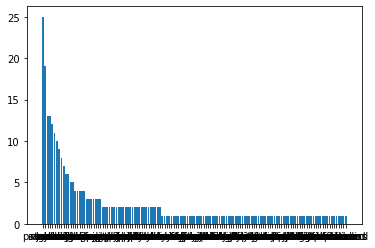

fruity 160 [('musk', 40), ('sandalwood', 37), ('jasmine', 27), ('vanilla', 25), ('amber', 23), ('rose', 20), ('cedar', 20), ('tuberose', 10), ('gardenia', 9), ('patchouli', 9), ('iris', 9), ('peach', 9), ('cashmere wood', 9), ('moss', 8), ('osmanthus', 7), ('peony', 7), ('leather', 6), ('geranium', 6), ('lily', 6), ('violet', 5), ('oakmoss', 5), ('plum', 5), ('apple', 5), ('wild jasmine', 5), ('cypress', 5), ('watery notes', 5), ('lavender', 4), ('honeysuckle', 4), ('white', 4), ('orris', 4), ('nutmeg', 4), ('lotus', 4), ('ylangylang', 4), ('orchid', 4), ('vanille', 4), ('labdanum', 3), ('caramel', 3), ('tonka bean', 3), ('cardamom', 3), ('cacao', 3), ('orange blossom', 3), ('cyclamen', 3), ('wood', 3), ('magnolia', 3), ('amberwood', 3), ('tonka', 3), ('blossom', 3), ('orange', 3), ('cedarwood', 3), ('lilyofthevalley', 3), ('amber wood', 3), ('woodyfloral', 3), ('animalistic floral', 2), ('floral ambery woody', 2), ('tonka beans', 2), ('cinnamon', 2), ('pepper', 2), ('the', 2), ('of', 

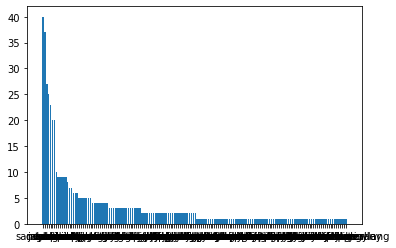

musk 24 [('musk', 6), ('vanilla', 4), ('rose', 4), ('patchouli', 3), ('cedar', 3), ('sandalwood', 2), ('amber', 2), ('ylangylang', 2), ('jasmine', 2), ('water', 2), ('guaiac wood', 2), ('saffron', 2), ('tonka bean', 2), ('cardamom', 2), ('heliotrope', 1), ('wood', 1), ('red', 1), ('white', 1), ('magnolia', 1), ('blossom', 1), ('lantana flower', 1), ('orange', 1), ('tail rose', 1), ('vanilla flowers', 1)]


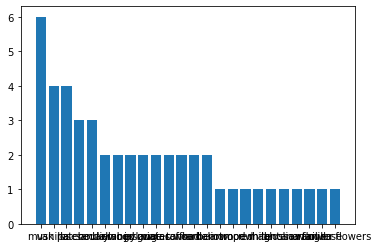

oriental 108 [('amber', 17), ('sandalwood', 16), ('jasmine', 15), ('musk', 13), ('vanilla', 12), ('rose', 11), ('patchouli', 10), ('vetiver', 9), ('cedar', 9), ('freesia', 5), ('tuberose', 5), ('geranium', 5), ('lavender', 4), ('woody', 4), ('violet', 4), ('oakmoss', 4), ('flowers', 4), ('iris', 3), ('heliotrope', 3), ('orchid', 3), ('lily of the valley', 3), ('carnation', 3), ('ylangylang', 3), ('bulgarian', 2), ('peony', 2), ('milk', 2), ('honey', 2), ('magnolia', 2), ('rosemary', 2), ('red', 2), ('hyacinth', 2), ('cuddly', 2), ('accords', 2), ('aromas', 2), ('warm', 2), ('cloves', 2), ('peach', 2), ('orris', 2), ('tonka bean', 2), ('centifolia', 2), ('damascus', 2), ('golden', 2), ('quince', 2), ('lily', 2), ('white', 2), ('cashmeran', 2), ('frangipani', 2), ('dry', 2), ('heliotropine', 2), ('pod', 2), ('osmanthus flower', 1), ('roasted cocoa', 1), ('coffee', 1), ('marshmallow', 1), ('rich', 1), ('musty', 1), ('oak moss', 1), ('cedarwood', 1), ('milky', 1), ('amber nuanced clary sag

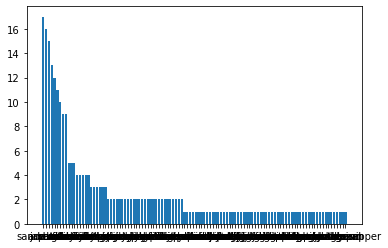

spicy 210 [('patchouli', 44), ('amber', 43), ('sandalwood', 34), ('musk', 31), ('vetiver', 31), ('cedar', 27), ('jasmine', 19), ('lavender', 19), ('cardamom', 19), ('rose', 18), ('sage', 18), ('geranium', 16), ('cinnamon', 16), ('vanilla', 16), ('leather', 14), ('tonka bean', 12), ('pepper', 11), ('nutmeg', 11), ('ginger', 10), ('iris', 9), ('benzoin', 9), ('apple', 9), ('tonka', 9), ('violet', 9), ('labdanum', 8), ('woody', 8), ('guaiac wood', 7), ('coumarin', 7), ('basil', 7), ('coriander', 7), ('notes', 7), ('wood', 7), ('orange blossom', 7), ('moss', 6), ('pink pepper', 6), ('woody notes', 6), ('oak moss', 6), ('black basil', 5), ('myrrh', 5), ('violet leaf', 5), ('bean', 5), ('cypress', 4), ('flower', 4), ('cedarwood', 4), ('spicy', 4), ('elemi', 4), ('dried fruit', 4), ('cashmere wood', 3), ('carnation', 3), ('coconut', 3), ('mint', 3), ('tonka beans', 3), ('cactus', 3), ('cashmeran', 3), ('white musk', 3), ('agarwood', 3), ('orange', 3), ('tobacco', 3), ('clary', 3), ('olibanum'

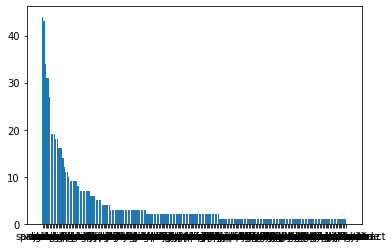

vanilla 78 [('vanilla', 14), ('musk', 11), ('amber', 9), ('jasmine', 6), ('tonka beans', 5), ('sandalwood', 5), ('patchouli', 4), ('pineapple', 4), ('iris', 4), ('sage', 3), ('cinnamon', 3), ('cedar', 3), ('lavender', 3), ('praline', 3), ('apple', 3), ('chilled vodka', 3), ('king wood', 3), ('of', 3), ('tonka', 3), ('hot', 3), ('ginger', 3), ('beans', 3), ('slice', 3), ('salty', 3), ('rose', 3), ('chestnut', 2), ('melon', 2), ('amber wood', 2), ('guaiac wood', 2), ('ylangylang', 2), ('white musk', 2), ('orange tree blossom', 2), ('benzoin', 2), ('jasmine tea', 2), ('coffee', 2), ('orrange blossom', 2), ('white wood', 2), ('bourbon vanilla', 2), ('sensuality', 2), ('sensual oriental character  gaiac wood', 2), ('spicy', 2), ('subtle', 2), ('floral petal', 2), ('pepper', 2), ('cardamom', 2), ('green', 2), ('verbena', 1), ('grapefruit blossom', 1), ('jacaranda wood', 1), ('sweet napolitano cake', 1), ('luid sandalwood', 1), ('tonka bean', 1), ('woody notes', 1), ('tiare flower', 1), ('mad

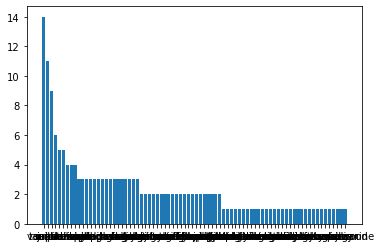

woody 304 [('musk', 78), ('amber', 76), ('patchouli', 69), ('sandalwood', 69), ('vetiver', 58), ('cedar', 56), ('jasmine', 54), ('vanilla', 45), ('rose', 39), ('leather', 33), ('oakmoss', 31), ('geranium', 23), ('iris', 19), ('tonka bean', 18), ('cinnamon', 18), ('ylangylang', 17), ('incense', 15), ('violet', 15), ('sage', 14), ('suede', 14), ('benzoin', 13), ('nutmeg', 13), ('lavender', 13), ('tuberose', 12), ('cardamom', 12), ('cedarwood', 11), ('woody notes', 11), ('tonka', 10), ('guaiac wood', 9), ('wood', 9), ('labdanum', 9), ('cedar wood', 8), ('cypress', 8), ('freesia', 7), ('lilyofthevalley', 7), ('carnation', 7), ('notes', 7), ('virginia cedar', 7), ('cashmere wood', 7), ('haitian vetiver', 7), ('honey', 6), ('spices', 6), ('tobacco', 6), ('clary sage', 6), ('almond', 6), ('woody', 6), ('ginger', 6), ('bean', 6), ('pepper', 6), ('moss', 6), ('black', 6), ('basil', 5), ('white musk', 5), ('white', 5), ('lily of the valley', 5), ('muguet', 5), ('fir', 5), ('neroli', 5), ('styrax

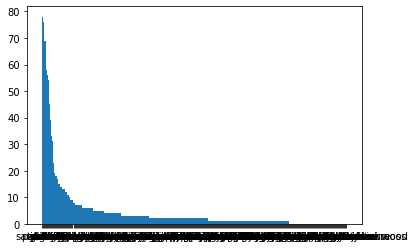

In [250]:
import matplotlib.pyplot as plt
import numpy as np

for scent in scents_sorted:
    x = np.arange(len(TailCutter[scent]))
    Notes = []
    Count = []
    for it in TailCutter[scent]:
        Notes.append(it[0])
        Count.append(it[1])

    plt.bar(x, Count)
    plt.xticks(x, Notes)

    print(scent, len(TailCutter[scent]), TailCutter[scent])
    plt.show()

# ** 3. Neural Network **

In [203]:
Data_x = [[0] * len(notes_sorted) for _ in range(len(perfumes))]
Data_y = [[0] * len(scents_sorted) for _ in range(len(perfumes))]
for i in range(len(perfumes)):
    perfume = perfumes[i]
    data_x = list(perfume[10] | perfume[9])
    data_y = list(perfume[8])[0]
    for data in data_x:
        if data not in notes_sorted:
            continue
        Data_x[i][notes_sorted.index(data)] = 1
    Data_y[i][scents_sorted.index(data_y)] = 1

In [ ]:
Data_y

In [205]:
X_all = np.array(Data_x)
y_all = np.array(Data_y)
X_train, X_test = X_all[:800], X_all[801:]
y_train, y_test = y_all[:800], y_all[801:]

In [206]:
print(X_train.shape)
print(y_train.shape)

(800, 861)
(800, 11)


In [207]:
X_train[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [208]:
y_train[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [219]:
from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling1D

model = keras.Sequential()

# model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
# model.add(MaxPooling1D(pool_size=2, padding='same',))
# model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
model.add(Dense(11, activation='softmax'))

In [220]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [221]:
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
20/20 [==============================] - 1s 14ms/step - loss: 2.2869 - accuracy: 0.2672 - val_loss: 2.1283 - val_accuracy: 0.3375
Epoch 2/10
20/20 [==============================] - 0s 9ms/step - loss: 1.9925 - accuracy: 0.3594 - val_loss: 1.9359 - val_accuracy: 0.3438
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 1.7402 - accuracy: 0.4281 - val_loss: 1.8488 - val_accuracy: 0.4000
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 1.4786 - accuracy: 0.5422 - val_loss: 1.7808 - val_accuracy: 0.4187
Epoch 5/10
20/20 [==============================] - 0s 8ms/step - loss: 1.2076 - accuracy: 0.6734 - val_loss: 1.7260 - val_accuracy: 0.5000
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 0.9436 - accuracy: 0.7781 - val_loss: 1.6973 - val_accuracy: 0.5125
Epoch 7/10
20/20 [==============================] - 0s 7ms/step - loss: 0.7325 - accuracy: 0.8203 - val_loss: 1.7372 - val_accuracy: 0.5125
Epoch 8/10
20/20 [=

In [222]:
loss_test, acc_test = model.evaluate(X_test, y_test)

print(loss_test)
print(acc_test)

7/7 [==============================] - 0s 4ms/step - loss: 1.8919 - accuracy: 0.4802
1.891902208328247
0.4801980257034302


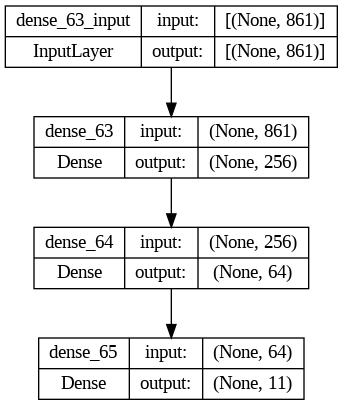

In [223]:
keras.utils.plot_model(model, show_shapes=True)

In [224]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 256)               220672    
                                                                 
 dense_64 (Dense)            (None, 64)                16448     
                                                                 
 dense_65 (Dense)            (None, 11)                715       
                                                                 
Total params: 237,835
Trainable params: 237,835
Non-trainable params: 0
_________________________________________________________________


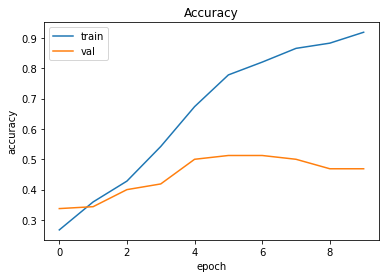

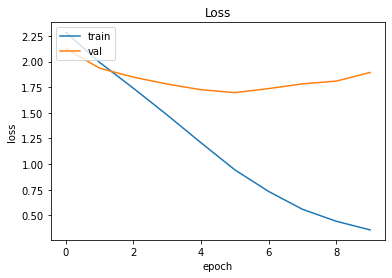

In [225]:
# 10. 학습 시각화하기
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()